### File Setup

In [4]:
CONTROLNET_MODEL_FOLDER = "hf_controlnet_model"
SD_MODEL_FOLDER = "hf_sd_model"

In [ ]:
!pip install -r requirements.txt

In [ ]:
# Download a local copy of the ControlNet model in `diffusers` format
!git clone https://huggingface.co/lllyasviel/sd-controlnet-canny {CONTROLNET_MODEL_FOLDER}

In [ ]:
# Download a StableDiffusion safetensors file
!mkdir -p {SD_MODEL_FOLDER}
!wget -O {SD_MODEL_FOLDER}/photographyAnd_10.safetensors https://civitai.com/api/download/models/9077

In [8]:
# Retrieve the converter script (already in the repo, keeping cell for posterity)
# !wget -O enhanced_convert_original_stable_diffusion_to_diffusers.py https://gist.githubusercontent.com/Pyr-000/8513eb989e44d7c4085216fab452d749/raw/2f26a22fe55cb82ce216ad0a035c07558678f6db/enhanced_convert_original_stable_diffusion_to_diffusers.py

In [ ]:
# Convert the `.safetensors` model into `diffusers` format`
!python enhanced_convert_original_stable_diffusion_to_diffusers.py --checkpoint_path {SD_MODEL_FOLDER}/photographyAnd_10.safetensors --dump_path {SD_MODEL_FOLDER} --extract_ema

In [10]:
# Sample control input image
!wget -O buildings-canny-input.jpg https://img.freepik.com/free-vector/city-skyline-concept-illustration_114360-8923.jpg

--2023-06-16 02:11:06--  https://img.freepik.com/free-vector/city-skyline-concept-illustration_114360-8923.jpg
Resolving img.freepik.com (img.freepik.com)... 23.53.112.59, 2600:1402:9800:494::312e, 2600:1402:9800:48d::312e
Connecting to img.freepik.com (img.freepik.com)|23.53.112.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55315 (54K) [image/jpeg]
Saving to: ‘buildings-canny-input.jpg’

buildings-canny-inp 100%[===================>]  54.02K  --.-KB/s    in 0.02s   

2023-06-16 02:11:06 (3.27 MB/s) - ‘buildings-canny-input.jpg’ saved [55315/55315]



### Inference

In [11]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL_FOLDER,
    torch_dtype=torch.float16,
    local_files_only=True
)

In [12]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    SD_MODEL_FOLDER,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    local_files_only=True
)
pipe.to("cuda") # Comment this out if you're using CPU
pipe.enable_sequential_cpu_offload()

In [13]:
import cv2
from PIL import Image
import numpy as np

def get_canny_image(input_3d_img: Image.Image) -> Image.Image:
    img_arr = np.array(input_3d_img)

    low_threshold = 100
    high_threshold = 200

    img_arr = cv2.Canny(img_arr, low_threshold, high_threshold)
    img_arr = img_arr[:, :, None]
    img_arr = np.concatenate([img_arr, img_arr, img_arr], axis=2)
    canny_image = Image.fromarray(img_arr)
    return canny_image

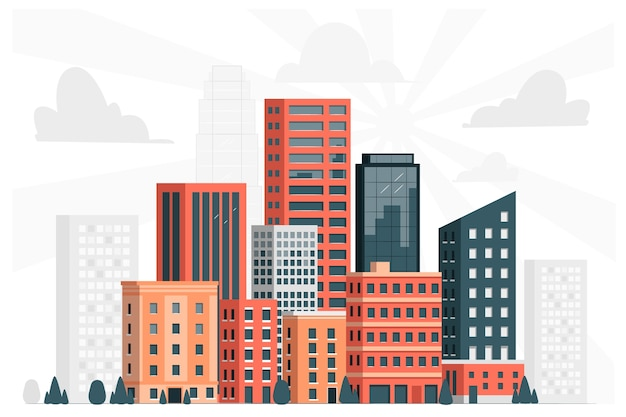

In [19]:
CONTROL_IMAGE_PATH = "buildings-canny-input.jpg"
input_control_image = Image.open(CONTROL_IMAGE_PATH)
input_control_image

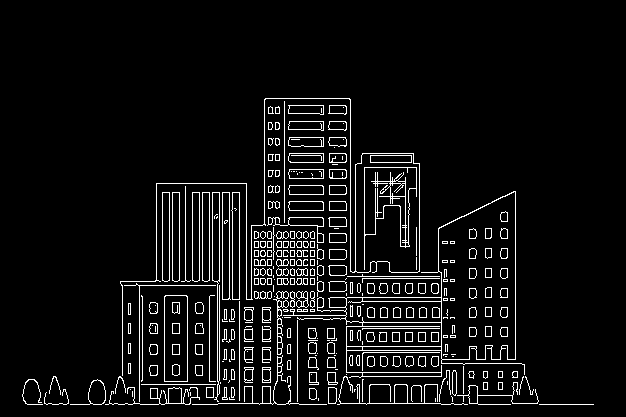

In [20]:
canny_image = get_canny_image(input_control_image)
canny_image

In [21]:
prompt = "scenery, lamppost, bicycle, crosswalk, sky, outdoors, no humans, ground vehicle, road, building, street, city, tree, traffic light, road sign, sunset, window, cityscape, cloud, sign, night, motor vehicle"
negative_prompt = "(normal quality), (low quality), (worst quality), paintings, sketches,soft line,fog"

generator = torch.Generator(device="cuda").manual_seed(42)

  0%|          | 0/20 [00:00<?, ?it/s]

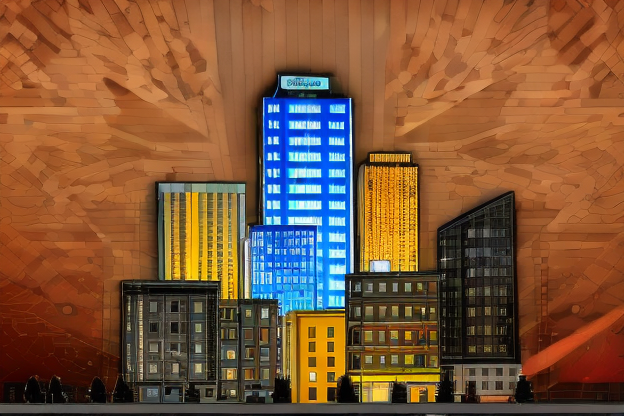

In [15]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
)
output.images[0]